# Demonstrate Text-Summarization Using Built-In Chains and LangGraph

**Suppose you have a set of documents (PDFs, Notion Pages, Customer questions, etc..) and you want to summarize the content**

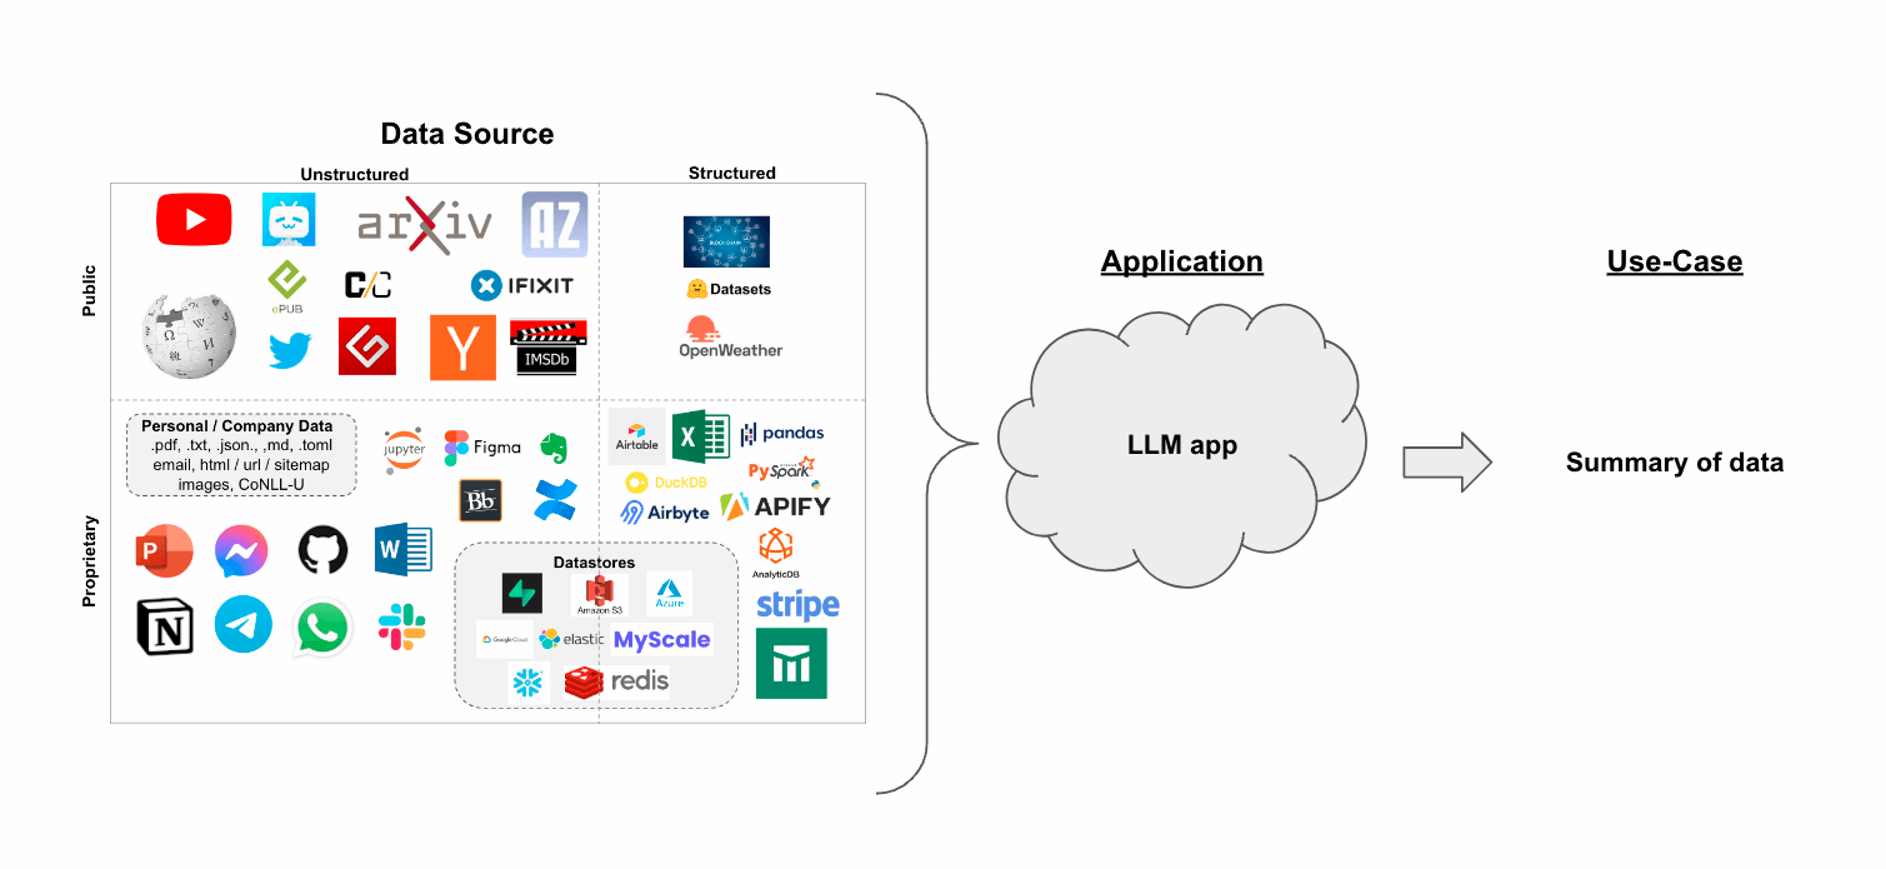

## Setup

In [2]:
# import libraries
import os
import sys
import time
import random
import string
import requests
import json
import base64
import re
import getpass

In [3]:
# Store your Hugging Face API key as a secret if it doesn't exist
try:
  secret_hf = os.get('HF_API_KEY')
except Exception as e:

  # Prompt the user to enter their API key and store it as a secret
  from getpass import getpass
  HF_API_KEY = getpass("Please enter your Hugging Face API key: ")
  #userdata.set('huggingface_api_key', huggingface_api_key) # This function is not fully supported in the current environment.
  #Instead, we will store the API key in an environment variable for this session.
  import os
  os.environ['HF_API_KEY'] = HF_API_KEY
  secret_hf = HF_API_KEY

Please enter your Hugging Face API key: ··········


In [4]:
# Store your groq_api_key as a secret if it doesn't exist
try:
  secret_hf = os.get('groq_api_key')
except Exception as e:

  # Prompt the user to enter their API key and store it as a secret
  from getpass import getpass
  groq_api_key = getpass("Please enter your groq_api_key : ")

  import os
  os.environ['groq_api_key'] = groq_api_key
  secret_hf = groq_api_key

Please enter your groq_api_key : ··········


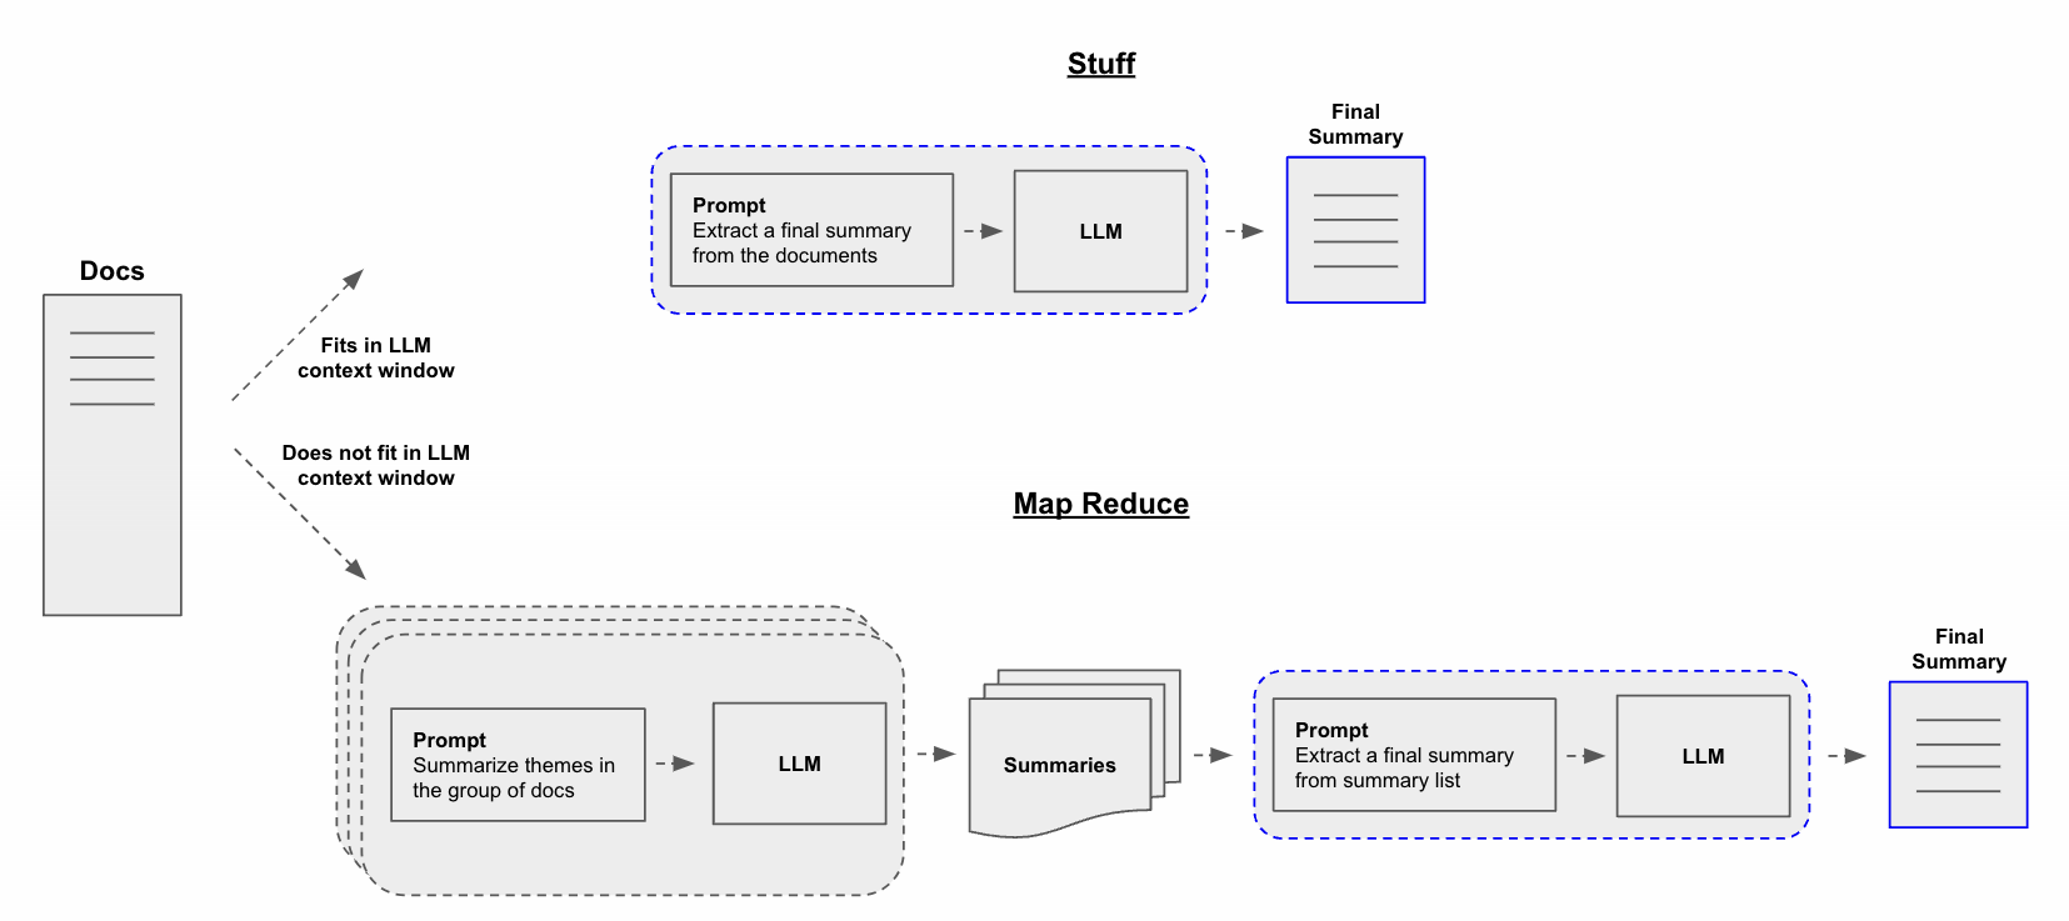

**Note that map-reduce is especilly effective when understanding a sub document does not rely on preceding context. For exanmple, when summarizing a corpus of many, shorter documents. In other cases, such as summarizing a novel or body of text with an inherent with an inherent sequence, iterative refinement may be more effective.**

In [5]:
# Load our documents we will use for the test
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [6]:
docs[0].page_content

'\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The

In [25]:
# select a chat model
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = 'gemma2-9b-it', groq_api_key = os.environ['groq_api_key'])
#
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is **Paris**. 🇫🇷  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_time': 0.027272727, 'prompt_time': 0.001917287, 'queue_time': 0.017501893, 'total_time': 0.029190014}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--20ba04c6-1c6c-44cb-976e-cf7b9b12190d-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31})

## Stuff: Summarize in a single LLM Call

**We can use create_stuff_documents_chain, especially if using larger context window models such as:**
- 128k token OpenAI gpt-4

In [26]:
speech="""
People across the country, involved in government, political, and social activities, are dedicating their time to make the ‘Viksit Bharat Sankalp Yatra’ (Developed India Resolution Journey) successful. Therefore, as a Member of Parliament, it was my responsibility to also contribute my time to this program. So, today, I have come here just as a Member of Parliament and your ‘sevak’, ready to participate in this program, much like you.

In our country, governments have come and gone, numerous schemes have been formulated, discussions have taken place, and big promises have been made. However, my experience and observations led me to believe that the most critical aspect that requires attention is ensuring that the government’s plans reach the intended beneficiaries without any hassles. If there is a ‘Pradhan Mantri Awas Yojana’ (Prime Minister’s housing scheme), then those who are living in jhuggis and slums should get their houses. And he should not need to make rounds of the government offices for this purpose. The government should reach him. Since you have assigned this responsibility to me, about four crore families have got their ‘pucca’ houses. However, I have encountered cases where someone is left out of the government benefits. Therefore, I have decided to tour the country again, to listen to people’s experiences with government schemes, to understand whether they received the intended benefits, and to ensure that the programs are reaching everyone as planned without paying any bribes. We will get the real picture if we visit them again. Therefore, this ‘Viksit Bharat Sankalp Yatra’ is, in a way, my own examination. I want to hear from you and the people across the country whether what I envisioned and the work I have been doing aligns with reality and whether it has reached those for whom it was meant.

It is crucial to check whether the work that was supposed to happen has indeed taken place. I recently met some individuals who utilized the Ayushman card to get treatment for serious illnesses. One person met with a severe accident, and after using the card, he could afford the necessary operation, and now he is recovering well. When I asked him, he said: “How could I afford this treatment? Now that there is the Ayushman card, I mustered courage and underwent an operation. Now I am perfectly fine.”  Such stories are blessings to me.

The bureaucrats, who prepare good schemes, expedite the paperwork and even allocate funds, also feel satisfied that 50 or 100 people who were supposed to get the funds have got it. The funds meant for a thousand villages have been released. But their job satisfaction peaks when they hear that their work has directly impacted someone’s life positively. When they see the tangible results of their efforts, their enthusiasm multiplies. They feel satisfied. Therefore, ‘Viksit Bharat Sankalp Yatra’ has had a positive impact on government officers. It has made them more enthusiastic about their work, especially when they witness the tangible benefits reaching the people. Officers now feel satisfied with their work, saying, “I made a good plan, I created a file, and the intended beneficiaries received the benefits.” When they find that the money has reached a poor widow under the Jeevan Jyoti scheme and it was a great help to her during her crisis, they realise that they have done a good job. When a government officer listens to such stories, he feels very satisfied.

There are very few who understand the power and impact of the ‘Viksit Bharat Sankalp Yatra’. When I hear people connected to bureaucratic circles talking about it, expressing their satisfaction, it resonates with me. I’ve heard stories where someone suddenly received 2 lakh rupees after the death of her husband, and a sister mentioned how the arrival of gas in her home transformed her lives. The most significant aspect is when someone says that the line between rich and poor has vanished. While the slogan ‘Garibi Hatao’ (Remove Poverty) is one thing, but the real change happens when a person says, “As soon as the gas stove came to my house, the distinction between poverty and affluence disappeared.
"""

In [27]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.chat_models import init_chat_model
from langchain.schema import SystemMessage, HumanMessage

#define the prompt
chat_message=[
    SystemMessage(content="You are expert with experise in summarizing speeched"),
    HumanMessage(content=f"Please provide a short and concisse summary of the follow speech:\n Text:{speech}")
]

#instantiate the chain

llm(chat_message)

AIMessage(content='The speaker, a Member of Parliament, emphasizes the importance of ensuring government schemes effectively reach their intended beneficiaries.  \n\nHe highlights the "Viksit Bharat Sankalp Yatra" (Developed India Resolution Journey) as a platform to assess the impact of these programs firsthand. Through personal anecdotes and interactions with government officers and citizens, the speaker demonstrates how these schemes are directly improving lives. He emphasizes the satisfaction and motivation felt by both officials and beneficiaries when they witness tangible results. \n\nThe speaker concludes by expressing the significance of the "Viksit Bharat Sankalp Yatra" in bridging the gap between the rich and poor, ultimately leading to a more equitable society. \n\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 890, 'total_tokens': 1028, 'completion_time': 0.250909091, 'prompt_time': 0.039032185, 'queue_time': 0.0194686

In [28]:
from langchain_core.prompts import PromptTemplate

generictemplate="""
Write a summary of the following speech:
Speech:{speech}
Translate the precise summary to {language}
"""

prompt=PromptTemplate(
    input_variables=['speech','language'],
    template=generictemplate)

complete_prompt=prompt.format(speech=speech,language="French")

In [29]:
llm_chain = LLMChain(llm=llm, prompt=prompt)
response = llm_chain.run({'speech': speech, 'language': 'French'})
response

"## Résumé de l'allocution \n\nCette allocution met en lumière l'importance du **Viksit Bharat Sankalp Yatra** (Voyage pour une Résolution pour l'Inde Développée) pour s'assurer que les programmes gouvernementaux atteignent les bénéficiaires les plus méritants. \n\nLe locuteur, en tant que Membre du Parlement, souligne son engagement personnel à travers ce voyage afin de :\n\n* **Évaluer l'efficacité des programmes gouvernementaux**: Vérifier si les bénéficiaires reçoivent effectivement les avantages escomptés et identifier les obstacles à leur accès.\n* **Renforcer la satisfaction des fonctionnaires**: Montrer aux fonctionnaires l'impact direct de leur travail sur la vie des gens et les motiver à poursuivre leurs efforts.\n\nLe locuteur partage des exemples concrets d'impact positif des programmes gouvernementaux, comme l'accès aux soins médicaux grâce à la carte Ayushman et la distribution de gaz, illustrant ainsi la disparition des barrières entre les riches et les pauvres.\n\nIl co

In [30]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("/content/drive/MyDrive/apjspeech.pdf")
docs = loader.load_and_split()
docs

[Document(metadata={'producer': 'GPL Ghostscript 8.15', 'creator': 'PScript5.dll Version 5.2', 'creationdate': 'D:20070730160943', 'moddate': 'D:20070730160943', 'title': 'Microsoft Word - Document1', 'author': 'Shri', 'source': '/content/drive/MyDrive/apjspeech.pdf', 'total_pages': 7, 'page': 0, 'page_label': '1'}, page_content='A P J Abdul Kalam Departing speech \n \n \nFriends, I am delighted to address you all, in the country and those living abroad, after \nworking with you and completing five beautiful and eventful years in Rashtrapati \nBhavan. Today, it is indeed a thanks giving occasion. I would like to narr ate, how I \nenjoyed every minute of my tenure enriched by the wonderful assoc iation from each one \nof you, hailing from different walks of life, be it politics, sci ence and technology, \nacademics, arts, literature, business, judiciary, administration, local bodies, farming, \nhome makers, special children, media and above all from the youth and st udent \ncommunity wh

In [31]:
template=""" Write a concise and short summary of the following speech,
Speech :{text}

 """
prompt=PromptTemplate(input_variables = ['text'],
                      template = template)

from langchain.chains.summarize import load_summarize_chain

chain=load_summarize_chain(llm, chain_type= 'stuff' ,prompt = prompt, verbose = True)
output_summary=chain.run(docs)
output_summary



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
 Write a concise and short summary of the following speech,
Speech :A P J Abdul Kalam Departing speech 
 
 
Friends, I am delighted to address you all, in the country and those living abroad, after 
working with you and completing five beautiful and eventful years in Rashtrapati 
Bhavan. Today, it is indeed a thanks giving occasion. I would like to narr ate, how I 
enjoyed every minute of my tenure enriched by the wonderful assoc iation from each one 
of you, hailing from different walks of life, be it politics, sci ence and technology, 
academics, arts, literature, business, judiciary, administration, local bodies, farming, 
home makers, special children, media and above all from the youth and st udent 
community who are the future wealth of our country. During my intera ction at 
Rashtrapati Bhavan in Delhi and at every state and union territor y as well as through my 
online int

'In his departing speech, A.P.J. Abdul Kalam reflects on his five years as President of India, highlighting key themes and inspiring messages.  \n\nHe emphasizes the need for **accelerated development**, driven by the aspirations of India\'s youth. He stresses the importance of **empowering villages**, improving connectivity, and **mobilizing rural core competence** for economic growth.\n\nKalam advocates for a **"Seed to Food" approach** to agricultural development, promoting sustainability and doubling agricultural production. He celebrates the **courage and resilience of people** in overcoming challenges, exemplified by his experiences in earthquake-affected areas and with people with disabilities.\n\nHe underscores the importance of **connectivity** for societal transformation, citing the Pan African e-Network initiative. He expresses his pride in India\'s **defense forces** and their commitment to national security.\n\nFinally, Kalam calls for a **youth movement** for a developed 

## Map Reduce: Summarize the long texts via parrelization

In [32]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100,
    length_function=len
)
docs_split = text_splitter.split_documents(docs)
docs_split

[Document(metadata={'producer': 'GPL Ghostscript 8.15', 'creator': 'PScript5.dll Version 5.2', 'creationdate': 'D:20070730160943', 'moddate': 'D:20070730160943', 'title': 'Microsoft Word - Document1', 'author': 'Shri', 'source': '/content/drive/MyDrive/apjspeech.pdf', 'total_pages': 7, 'page': 0, 'page_label': '1'}, page_content='A P J Abdul Kalam Departing speech \n \n \nFriends, I am delighted to address you all, in the country and those living abroad, after \nworking with you and completing five beautiful and eventful years in Rashtrapati \nBhavan. Today, it is indeed a thanks giving occasion. I would like to narr ate, how I \nenjoyed every minute of my tenure enriched by the wonderful assoc iation from each one \nof you, hailing from different walks of life, be it politics, sci ence and technology, \nacademics, arts, literature, business, judiciary, administration, local bodies, farming, \nhome makers, special children, media and above all from the youth and st udent \ncommunity wh

In [33]:
chunks_prompt="""
Please summarize the below speech:
Speech:`{text}'
Summary:
"""
map_prompt_template = PromptTemplate(input_variables = ['text'],
                                    template = chunks_prompt)

final_prompt='''
Provide the final summary of the entire speech with these important points.
Add a Motivation Title,Start the precise summary with an introduction and provide the summary in number
points for the speech.
Speech:{text}

'''
final_prompt_template = PromptTemplate(input_variables = ['text'],
                                       template = final_prompt)

## Orchestration Via LangGraph

In [34]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt_template.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = final_prompt_template.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

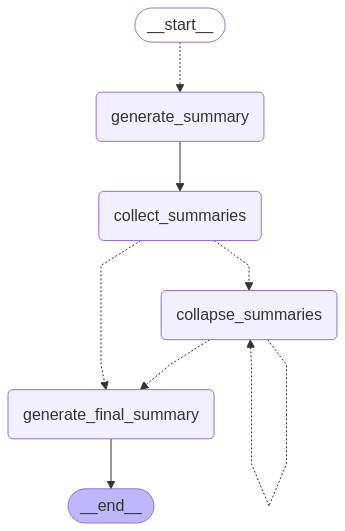

In [35]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [36]:
async for step in app.astream(
    {'contents': [doc.page_content for doc in docs_split]},
    {'recursion_limit': 10}
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [37]:
print(step)

{'generate_final_summary': {'final_summary': "##  Unleashing India's Potential: A Vision for a Developed Nation \n\nThis speech by Dr. Kalam provides a roadmap for India's future, outlining key strategies and emphasizing the role of youth, rural development, and collaborative efforts in achieving national growth and prosperity by 2020.\n\nHere are the key messages:\n\n1. **Accelerated Development:** India must prioritize faster and more impactful development across all sectors to fulfill the aspirations of its youthful population.\n2. **Empowering Villages:** Dr. Kalam stresses the need for targeted development initiatives to uplift rural communities and harness their potential. \n3. **Rural Talent Mobilization:** Recognizing the skills and talent within rural populations is crucial for building a nationally competitive workforce.\n4. **Strengthening Agriculture:**  Ensuring food security and agricultural growth is paramount, requiring support and investment in the agricultural sector.

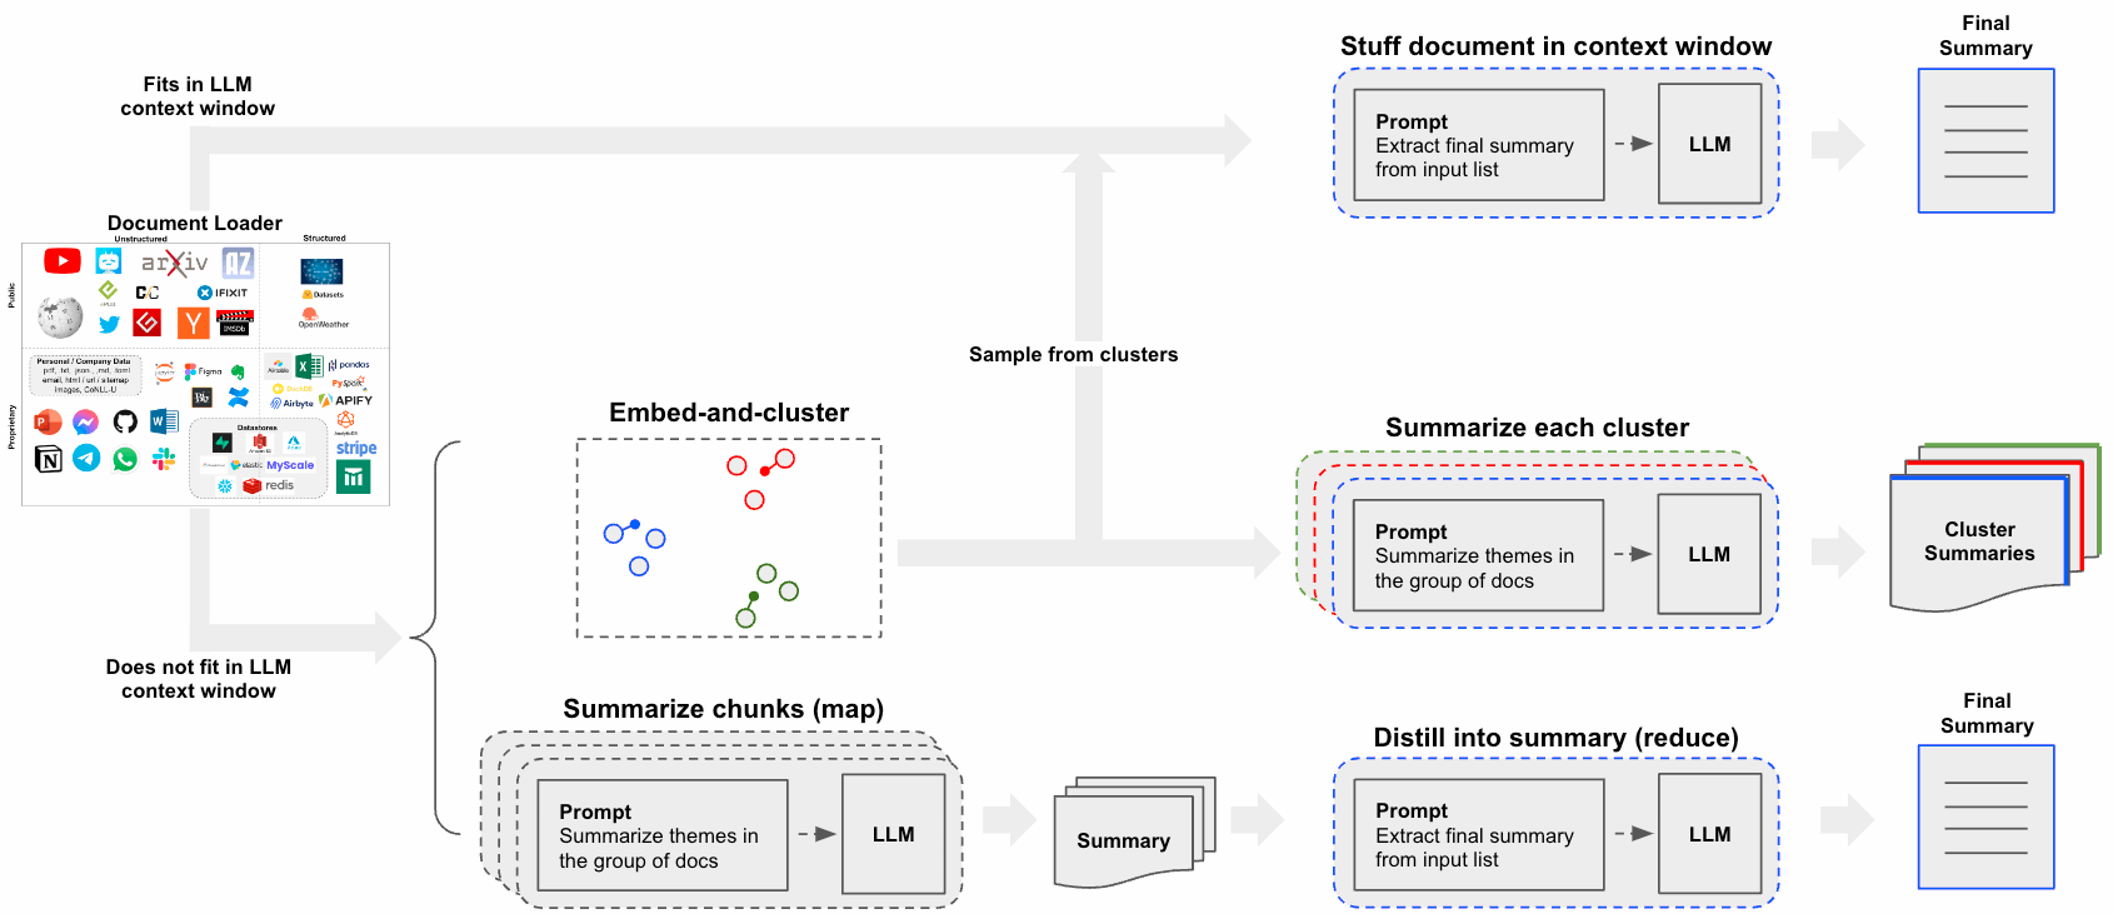

## Iterative Refinement: Summarizes long text

the strategy follows:
- Split a text into smaller documents.
- Summarize the first document.
- Refine or update the result based on the next context.
- Repeat through the sequence of documents until finished.

In [38]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

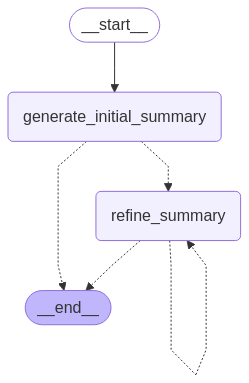

In [39]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [40]:
async for step in app.astream(
    {'contents': [doc.page_content for doc in docs_split]},
    stream_mode= 'values'
):
  if summary := step.get('summary'):
    print(summary)

In his departing speech, A.P.J. Abdul Kalam reflects on his five years as President, expressing gratitude for the interactions with diverse segments of Indian society. He outlines ten key messages gleaned from these experiences, emphasizing:

* **Accelerated Development:** Driven by the aspirations of India's youth.
* **Empowering Villages:** Recognizing their crucial role in national progress.
* **Harnessing Rural Potential:** Mobilizing rural resources for economic competitiveness.
* **Agricultural Growth:** Emphasizing the importance of the "Seed to Food" chain.
* **Overcoming Challenges:** Encouraging perseverance and success through problem-solving.
* **Collaborative Solutions:**  Promoting partnerships to address national issues.
* **Resilience in Crisis:**  Demonstrating courage and unity in the face of calamities.
* **Connectivity as a Driver:**  Leveraging connectivity for societal transformation.
* **National Security:**  Highlighting the importance of defending the nation.
*